In [1]:
!pip install underthesea 
!pip -q install pandarallel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 79.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter
import json
import re
from underthesea import text_normalize, word_tokenize
from pandarallel import pandarallel
from multiprocessing import cpu_count
from sklearn.model_selection import train_test_split

In [3]:
train_path = "/kaggle/input/data-nlp-30k/train.csv"
test_path = "/kaggle/input/data-nlp-30k/test.csv"
text_col = "Text_Processing"
label_col = "Labels"
stopwords_path = "/kaggle/input/vietnamese-stopwords/vietnamese-stopwords-dash.txt"

# vocab
max_vocab = 50000
min_freq = 1
PAD = 0
OOV = 1

# training
batch_size = 64
emb_dim = 128
hidden_dim = 128
dropout = 0.3
lr = 2e-3
epochs = 10
patience_epoch = 5
num_workers = 4

# device
device = "cuda" if torch.cuda.is_available() else "cpu"

# LOAD DATA

In [4]:
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

In [5]:
train_df

,Labels,Text
0,Chinh tri Xa hoi,Thành lập dự án POLICY phòng chống HIV/AIDS ở ...
1,Chinh tri Xa hoi,Hơn 16.000 khách đến vịnh Nha Trang Theo trực ...
2,Chinh tri Xa hoi,TPHCM: Khai trương dịch vụ lặn biển săn cá mập...
3,Chinh tri Xa hoi,Du lịch VN sẽ có tư vấn nước ngoài Ông Phạm Từ...
4,Chinh tri Xa hoi,Quy chế tuyển sinh 2006: Không làm tròn điểm t...
...,...,...
33754,Vi tinh,Điện thoại di động tương lai trông như thế nào...
33755,Vi tinh,Internet sẽ tăng tốc 1.000 lần \nTrong tương l...
33756,Vi tinh,Phần lớn thế giới thứ 3 thất bại với chính phủ...
33757,Vi tinh,'Doom 3' giành chiến thắng kép \nTrò chơi hành...


In [6]:
test_df

,Labels,Text
0,Chinh tri Xa hoi,Mạo hiểm rừng Đa Mi Cuộc hành quân khám phá th...
1,Chinh tri Xa hoi,Tàu du lịch cao tốc Cần Thơ - Phnom Penh Công ...
2,Chinh tri Xa hoi,Miền Trung được mùa khách Thái Đoàn du khách T...
3,Chinh tri Xa hoi,7 kỳ quan mới của thế giới Cầu Akashi - Kaikyo...
4,Chinh tri Xa hoi,Khối A thi được mấy trường? Thi khối A vào ĐH ...
...,...,...
50368,Vi tinh,Phần mềm chống tải nhạc bất hợp pháp\nNhóm ngh...
50369,Vi tinh,Linux tăng ảnh hưởng trên thị trường máy chủ\n...
50370,Vi tinh,Napster phát không máy nghe nhạc\nCông ty phát...
50371,Vi tinh,Intel giới thiệu chip và chipset chuyên biệt h...


# PREPROCESSING

In [7]:
class Preprocessing:
    def __init__(self, file_path):
        self.stopwords = self.read_stopwords(file_path)

        # compile regex 1 lần
        self.re_k     = re.compile(r'\b(\d+)k\b')
        self.re_pcent = re.compile(r'\b(\d+)%\b')
        self.re_m     = re.compile(r'\b(\d+)m\b')
        self.re_s     = re.compile(r'\b(\d+)s\b')
        self.re_min   = re.compile(r"\b(\d+)'\b")
        self.re_h     = re.compile(r'\b(\d+)h\b')
        self.re_non   = re.compile(r'[^0-9a-zA-ZÀ-ỹ\s]')

    def read_stopwords(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            return set(f.read().splitlines())

    def preprocessing_text(self, text):
        t = str(text).lower().strip()
        t = self.re_k.sub(r'\1 ngàn', t)
        t = self.re_pcent.sub(r'\1 phần trăm', t)
        t = self.re_m.sub(r'\1 mét', t)
        t = self.re_s.sub(r'\1 giây', t)
        t = self.re_min.sub(r'\1 phút', t)
        t = self.re_h.sub(r'\1 giờ', t)
        t = self.re_non.sub(' ', t)
        tokens = [w for w in t.split() if w not in self.stopwords]
        return " ".join(tokens)


In [8]:
pandarallel.initialize(progress_bar=True, nb_workers=cpu_count())

pre = Preprocessing(stopwords_path)

train_df["Text_Processing"] = (
    train_df["Text"].astype(str).parallel_apply(pre.preprocessing_text)
)
test_df["Text_Processing"] = (
    test_df["Text"].astype(str).parallel_apply(pre.preprocessing_text)
)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [9]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["Labels"])

In [10]:
val_df

,Labels,Text,Text_Processing
11846,Kinh doanh,Hàng dệt may sang Mỹ phải được cấp visa điện t...,hàng dệt may mỹ visa điện tử phủ việt nam mỹ k...
3391,Chinh tri Xa hoi,"Ông chủ tịch làm... ""ăn mày""\nSinh ra ở làng q...",chủ tịch mày sinh làng quê nghèo huyện miền nú...
6002,Doi song,Chị Hương hãy cho anh ấy một cơ hội\nNếu chị v...,hương hội thương hội hội hy vọng quyết định su...
2993,Chinh tri Xa hoi,"Quảng Nam, lốc lớn gây thiệt hại nặng tại các ...",quảng nam lốc thiệt hại xã sâu huyện hiệp đức ...
31705,Vi tinh,Hacker Nga bán rẻ mã nguồn tấn công Windows\nK...,hacker nga rẻ mã công windows kaspersky lab th...
...,...,...,...
2165,Chinh tri Xa hoi,Đại diện của nhiều trường trung học chuyên ngh...,đại diện trường trung học chuyên nghiệp thcn b...
28277,Van hoa,Miss Iceland đăng quang Hoa hậu thế giới 2005 ...,miss iceland đăng quang hoa hậu giới 2005 trái...
6913,Doi song,Phương phải nói chuyện với bạn trai của mẹ\nNế...,phương trai mẹ hoàn cảnh đàn chốt dừng quan hệ...
26426,The thao,Từ vô địch TP.HCM đến vô địch toàn nước Mỹ\nNă...,vô địch tp hcm vô địch toàn mỹ 33 phong 20 gắn...


In [11]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(27007, 3)
(50373, 3)
(6752, 3)


In [12]:
train_df = train_df.dropna(subset=[text_col, label_col])
val_df   = val_df.dropna(subset=[text_col, label_col])
test_df  = test_df.dropna(subset=[text_col, label_col])

X_train, y_train_raw = train_df[text_col].astype(str).tolist(), train_df[label_col].astype(str).tolist()
X_val,   y_val_raw   = val_df[text_col].astype(str).tolist(),   val_df[label_col].astype(str).tolist()
X_test,  y_test_raw  = test_df[text_col].astype(str).tolist(),  test_df[label_col].astype(str).tolist()

# Label encoder
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_val   = le.transform(y_val_raw)
y_test  = le.transform(y_test_raw)
num_classes = len(le.classes_)
print("Classes:", list(le.classes_))

Classes: ['Chinh tri Xa hoi', 'Doi song', 'Khoa hoc', 'Kinh doanh', 'Phap luat', 'Suc khoe', 'The gioi', 'The thao', 'Van hoa', 'Vi tinh']


# BUILD VOCAB

In [13]:
class Vocab:
    def __init__(self, max_size=50000, min_freq=1, pad_token="<PAD>", oov_token="<OOV>"):
        self.max_size = max_size
        self.min_freq = min_freq
        self.pad_token = pad_token
        self.oov_token = oov_token
        self.pad_idx, self.oov_idx = 0, 1
        self.itos = []
        self.stoi = {}

    def build(self, texts):
        counter = Counter()
        for s in texts:
            counter.update(self.tokenize(s))

        most_common = counter.most_common()
        if self.min_freq > 1:
            most_common = [kv for kv in most_common if kv[1] >= self.min_freq]
        most_common = most_common[: self.max_size]

        self.itos = [self.pad_token, self.oov_token] + [w for w, _ in most_common]
        self.stoi = {w: i for i, w in enumerate(self.itos)}
        return self

    def tokenize(self, s: str):
        return s.strip().split()

    def numericalize(self, text):
        return [self.stoi.get(tok, self.oov_idx) for tok in self.tokenize(text)]

    def denumericalize(self, ids):
        return [self.itos[i] if i < len(self.itos) else self.oov_token for i in ids]

    def save(self, path="vocab.json"):
        with open(path, "w", encoding="utf-8") as f:
            json.dump({"itos": self.itos}, f, ensure_ascii=False)

    def load(self, path="vocab.json"):
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
            self.itos = data["itos"]
            self.stoi = {w: i for i, w in enumerate(self.itos)}
        return self


In [14]:
vocab = Vocab(max_size=50000, min_freq=1).build(X_train)
print("NUmber of words in vocab:", len(vocab.itos))

NUmber of words in vocab: 50002


In [15]:
ids = vocab.numericalize("ronaldo ghi bàn thắng")
print(ids)
print(vocab.denumericalize(ids))

[1504, 319, 113, 84]
['ronaldo', 'ghi', 'bàn', 'thắng']


# DATASET + DATALOADER

In [16]:
class TxtClsDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        ids = torch.tensor(self.vocab.numericalize(self.texts[idx]), dtype=torch.long)
        y   = torch.tensor(self.labels[idx], dtype=torch.long)
        return ids, y

def collate_fn(batch):
    seqs, ys = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True, padding_value=PAD)
    ys = torch.stack(ys)
    return padded, lengths, ys

train_dataset = TxtClsDataset(X_train, y_train, vocab)
test_dataset = TxtClsDataset(X_test,  y_test, vocab)
val_dataset = TxtClsDataset(X_val,   y_val, vocab)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# MODEl

In [18]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_idx=0, dropout=0.3):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(emb_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, lengths):
        emb = self.emb(x)  # (B, L, E)
        mask = (x != PAD).unsqueeze(-1).float()
        summed = (emb * mask).sum(dim=1)       # (B, E)
        lengths = lengths.unsqueeze(1).clamp(min=1)
        avg = summed / lengths                 # (B, E)
        h = self.dropout(self.relu(self.fc1(avg)))
        out = self.fc2(h)                      # (B, num_classes)
        return out

model = TextClassifier(
    vocab_size=len(vocab.itos),
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    num_classes=num_classes,
    pad_idx=PAD,
    dropout=dropout
).to(device)

model

TextClassifier(
  (emb): Embedding(50002, 128, padding_idx=0)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# TRAIN

In [ ]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device="cpu"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

        # save results
        self.train_losses, self.val_losses = [], []
        self.train_accs, self.val_accs = [], []
        self.best_val_acc = 0.0

    def run_epoch(self, loader, train=True):
        if train: self.model.train()
        else:     self.model.eval()

        total_loss, correct, total = 0.0, 0, 0

        for x, lengths, y in loader:
            x, lengths, y = x.to(self.device), lengths.to(self.device), y.to(self.device)

            with torch.set_grad_enabled(train):
                logits = self.model(x, lengths)
                loss = self.criterion(logits, y)

                if train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            total_loss += loss.item() * y.size(0)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader, val_loader, epochs=10, save_path="best_model.pt", patience=3):
        patience_counter = 0
    
        for epoch in range(1, epochs+1):
            tr_loss, tr_acc = self.run_epoch(train_loader, train=True)
            va_loss, va_acc = self.run_epoch(val_loader, train=False)
    
            self.train_losses.append(tr_loss); self.train_accs.append(tr_acc)
            self.val_losses.append(va_loss);   self.val_accs.append(va_acc)
    
            print(f"Epoch {epoch:02d} | Train Loss={tr_loss:.4f}, Acc={tr_acc:.4f} "
                  f"| Val Loss={va_loss:.4f}, Acc={va_acc:.4f}")
    
            if va_acc > self.best_val_acc:
                self.best_val_acc = va_acc
                torch.save(self.model.state_dict(), save_path)
                patience_counter = 0 
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch} (no improvement in {patience} epochs).")
                    break

    def evaluate(self, loader, label_encoder=None, model_path="best_model.pt"):
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

        test_loss, test_acc = self.run_epoch(loader, train=False)
        print(f"\nTest Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

        # report
        all_preds, all_true = [], []
        with torch.no_grad():
            for x, lengths, y in loader:
                x, lengths = x.to(self.device), lengths.to(self.device)
                logits = self.model(x, lengths)
                preds = logits.argmax(1).cpu().numpy()
                all_preds.extend(preds)
                all_true.extend(y.numpy())

        if label_encoder is not None:
            target_names = label_encoder.classes_
        else:
            target_names = None

        print("\nClassification report:")
        print(classification_report(all_true, all_preds, target_names=target_names, digits=4))
        print("\nConfusion Matrix:")
        print(confusion_matrix(all_true, all_preds))

    def plot_curves(self):
        # Loss
        plt.figure()
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.legend(); plt.title("Loss curve")
        plt.show()

        # Accuracy
        plt.figure()
        plt.plot(self.train_accs, label="Train Acc")
        plt.plot(self.val_accs, label="Val Acc")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.legend(); plt.title("Accuracy curve")
        plt.show()

Epoch 01 | Train Loss=0.8342, Acc=0.7316 | Val Loss=0.4184, Acc=0.8630
Epoch 02 | Train Loss=0.3466, Acc=0.8858 | Val Loss=0.3680, Acc=0.8777
Epoch 03 | Train Loss=0.2531, Acc=0.9176 | Val Loss=0.3417, Acc=0.8868
Epoch 04 | Train Loss=0.1933, Acc=0.9366 | Val Loss=0.3422, Acc=0.8877
Epoch 05 | Train Loss=0.1431, Acc=0.9542 | Val Loss=0.3585, Acc=0.8894
Epoch 06 | Train Loss=0.1110, Acc=0.9653 | Val Loss=0.3811, Acc=0.8883
Epoch 07 | Train Loss=0.0846, Acc=0.9740 | Val Loss=0.3988, Acc=0.8879
Epoch 08 | Train Loss=0.0622, Acc=0.9817 | Val Loss=0.4306, Acc=0.8874
Epoch 09 | Train Loss=0.0480, Acc=0.9866 | Val Loss=0.4557, Acc=0.8851
Epoch 10 | Train Loss=0.0396, Acc=0.9883 | Val Loss=0.4825, Acc=0.8886
Early stopping at epoch 10 (no improvement in 5 epochs).

Test Loss=0.3316, Test Acc=0.8974

Classification report:
                  precision    recall  f1-score   support

Chinh tri Xa hoi     0.8404    0.8686    0.8543      7567
        Doi song     0.6778    0.6871    0.6824      2036

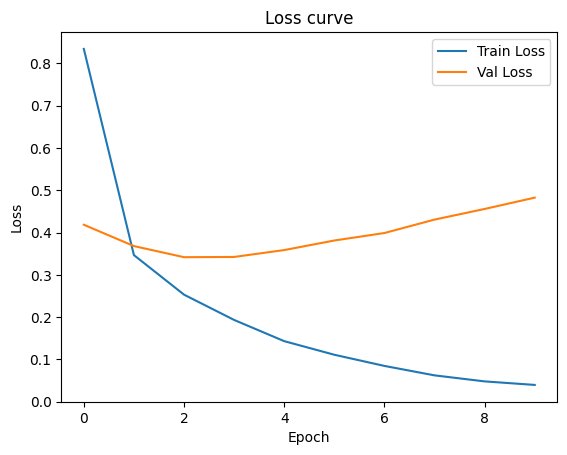

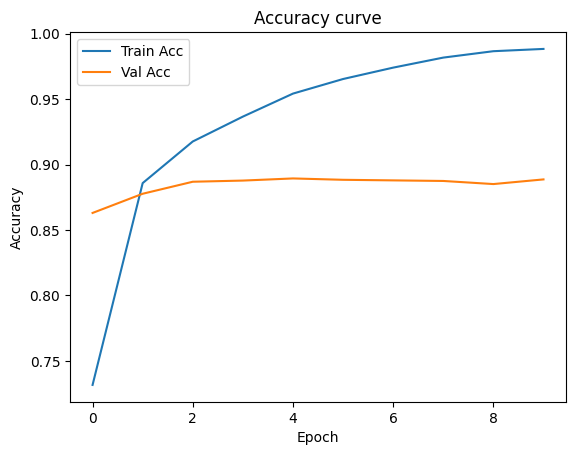

In [21]:
trainer = Trainer(model, criterion, optimizer, device=device)

# train 
trainer.fit(train_loader, val_loader, epochs=epochs, save_path="best_model.pt", patience = patience_epoch)

# Test
trainer.evaluate(test_loader, label_encoder=le, model_path="best_model.pt")

# plot
trainer.plot_curves()

In [ ]:
def predict(text):
    ids = torch.tensor([vocab.numericalize(text)], dtype=torch.long).to(device)
    lengths = torch.tensor([len(ids[0])], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(ids, lengths)
        pred = logits.argmax(1).item()
    
    return le.inverse_transform([pred])[0]

sample_texts = [
    "Bộ Y tế công bố ca bệnh mới liên quan đến dịch cúm.",
    "Bộ giáo dục quyết định cải cách."
]

for txt in sample_texts:
    print(f"{txt}  -->  {predict(txt)}")

Bộ Y tế công bố ca bệnh mới liên quan đến dịch cúm.  -->  Khoa hoc
Bộ giáo dục quyết định cải cách.  -->  Phap luat
